In [ ]:
!pip install bertopic[vision]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.7 MB/s eta 0:00:00


In [ ]:
import os,re
import glob
import zipfile
from tqdm import tqdm
from bertopic import BERTopic
from bertopic.representation import VisualRepresentation
from bertopic.representation import KeyBERTInspired
from PIL import Image
from collections import defaultdict



/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
!pip install -q gdown
import gdown
import zipfile

# Replace with your link
url = 'https://drive.google.com/file/d/1fcSazHYRhf6JdbbIXTE7D25ibnAUowEc/view?usp=sharing'

# Convert to direct download
file_id = url.split('/d/')[1].split('/')[0]
gdrive_url = f'https://drive.google.com/uc?id={file_id}'

# Download ZIP file
output = 'file.zip'
gdown.download(gdrive_url, output, quiet=False)

# Unzip it
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('unzipped')

print("✅ Unzipped to /content/unzipped")


Downloading...
From (original): https://drive.google.com/uc?id=1fcSazHYRhf6JdbbIXTE7D25ibnAUowEc
From (redirected): https://drive.google.com/uc?id=1fcSazHYRhf6JdbbIXTE7D25ibnAUowEc&confirm=t&uuid=52b229b4-82e3-42b8-8378-b74e7756a96f
To: /content/file.zip
100%|██████████| 705M/705M [00:03<00:00, 233MB/s]


✅ Unzipped to /content/unzipped


# Data Prep

In [ ]:
def load_data(image_folder='unzipped/fage_data/fage_jpg', # actual image files
              img_what_folder='unzipped/fage_data/fage_jpg_what', # "what narratives" for images
              img_who_folder='unzipped/fage_data/fage_jpg_who',# "who narratives" for images
              vid_what_folder='unzipped/fage_data/fage_mp4_what' # "what narratives" for videos
              ):

  #load image paths
  img_paths = list(glob.glob(image_folder+'/*.jpg'))

  #load narrative paths
  img_what_narrative_paths = list(glob.glob(img_what_folder+'/*.txt')) # "Describe this picture in Detail"
  img_who_narrative_paths = list(glob.glob(img_who_folder+'/*.txt')) #"Desribe 10 different audience segments that you think would find this picture interesting. Describe each Segment via a short phrase."

  data={} # maps the name of each media file to its "what" narrative, its "who" narrative, the actual image objevt, and the path to the image file

  #======================================

  #load what narratives
  for path in img_what_narrative_paths: # for each media file

    #get the file name
    fname = os.path.splitext(os.path.basename(path))[0].split('.')[0]

    # if we have a "what" narrative for the video, switch to that
    if os.path.exists(vid_what_folder+'/'+fname+'.mp4.txt'):
      path=vid_what_folder+'/'+fname+'.mp4.txt'

    with open(path) as f:
      data[fname]=[f.read()]

  #======================================

  #load who narratives
  for path in img_who_narrative_paths :

    #get the file name
    fname = os.path.splitext(os.path.basename(path))[0].split('.')[0]

    with open(path) as f:
      data[fname]+=[f.read()]

  #======================================

  #load image data
  for path in img_paths:
    #get the file name
    fname = os.path.splitext(os.path.basename(path))[0].split('.')[0]

    data[fname]+=[Image.open(path).convert("RGB"),path]
    #if len(data[fname])!=4: print(len(data[fname]),fname)

    assert len(data[fname]) == 4, 'We should Always have 4 values for each media file: what narrative, who narrative, image object, image file path'

  return zip(*data.values())


In [ ]:
what_narr, who_narr, images, image_paths=load_data()

In [ ]:
who_narr[0]

'1. Fruit enthusiasts interested in the variety of fruits presented.\n2. Home décor aficionados attracted to the styling and color coordination.\n3. Culinary artists looking for plating inspiration.\n4. Textile connoisseurs appreciating the fabric under the bowl.\n5. Tableware collectors observing the bowl and spoon design.\n6. Food photographers seeking composition ideas.\n7. Nutritionists interested in the display of healthy food choices.\n8. Cooking enthusiasts looking for meal presentation concepts.\n9. Recipe developers considering fruit pairings.\n10. Art students analyzing the use of negative space and balance in composition.'

# Topic Modeling

In [ ]:
from bertopic.backend import MultiModalBackend
model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

# Embed documents only
what_embeddings = model.embed_documents(what_narr)
who_embeddings = model.embed_documents(who_narr)

# Embeding images only
image_embeddings = model.embed_images(images,verbose=1)

super_embeddings=(what_embeddings + who_embeddings + image_embeddings) / 3

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Token indices sequence length is longer than the specified maximum sequence length for this model (159 > 77). Running this sequence through the model will result in indexing errors
100%|██████████| 41/41 [00:25<00:00,  1.59it/s]


In [ ]:
what_embeddings.shape

(1308, 512)

In [ ]:
from hdbscan import HDBSCAN
import csv
from sklearn.feature_extraction.text import CountVectorizer

def get_topics(
    image_paths:list,
    narratives:list,
    concept_outfile='concepts.csv',  # save the concepts for the training dataset
    model_outfile='fage_concept_model.mdl' # save the topic model
      ):

  hdbscan_model = HDBSCAN(min_cluster_size=30,
                          metric='euclidean',
                          cluster_selection_method='eom',
                          min_samples=5, # implicitly controls culster homogeneity
                          prediction_data = True # necessary to support inference later
                          )

  # Additional ways of representing a topic
  visual_model = VisualRepresentation(nr_repr_images=3)

  # Make sure to add the `visual_model` to a dictionary
  representation_model = {
    "Visual_Aspect":  visual_model,
  }

  vectorizer_model = CountVectorizer(stop_words="english")

  # Train our model with images only
  topic_model = BERTopic(
      vectorizer_model=vectorizer_model,
      embedding_model=None, # we have our own precomputed embeddings, no need for this
      representation_model=representation_model,
      hdbscan_model=hdbscan_model,
      nr_topics=False # does a post-processing step trying to merge topics with similar representations
      )

  #fit the model
  topics, probs = topic_model.fit_transform(documents=narratives, embeddings=super_embeddings, images=image_paths)

  #write the concepts
  with open(concept_outfile,'w') as fw:

    writer=csv.writer(fw)
    for i in range(len(image_paths)):
      writer.writerow([image_paths[i],'Concept'+str(topics[i])])

  topic_model.save(model_outfile)

  return topic_model,topics,probs



In [ ]:
topic_model,topics,probs = get_topics(image_paths=image_paths,
                           narratives=what_narr)

100%|██████████| 17/17 [00:02<00:00,  6.75it/s]
2025-11-06 17:19:45,870 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
topics[0]

3

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Visual_Aspect,Representative_Docs
0,-1,296,-1_yogurt_fage_white_red,"[yogurt, fage, white, red, green, image, total...",<PIL.Image.Image image mode=RGB size=1440x600 ...,[The video begins with a close-up shot of a wh...
1,0,121,0_bowl_image_yogurt_slices,"[bowl, image, yogurt, slices, green, wooden, r...",<PIL.Image.Image image mode=RGB size=1560x600 ...,[This image presents a delicious-looking bowl ...
2,1,120,1_glass_smoothie_layer_dessert,"[glass, smoothie, layer, dessert, jar, yogurt,...",<PIL.Image.Image image mode=RGB size=1440x600 ...,"[This image features a tall, clear glass fille..."
3,2,99,2_person_yogurt_hand_holding,"[person, yogurt, hand, holding, container, ima...",<PIL.Image.Image image mode=RGB size=1800x600 ...,[This image features a close-up of a person ho...
4,3,94,3_bowl_yogurt_red_image,"[bowl, yogurt, red, image, strawberries, fresh...",<PIL.Image.Image image mode=RGB size=1560x600 ...,[This image features a food arrangement that p...
5,4,74,4_yogurt_plain_extraordinary_shot,"[yogurt, plain, extraordinary, shot, spoonful,...",<PIL.Image.Image image mode=RGB size=1440x600 ...,[The advertisement begins with a vibrant close...
6,5,62,5_fage_yogurt_total_shot,"[fage, yogurt, total, shot, video, white, tubs...",<PIL.Image.Image image mode=RGB size=1440x600 ...,[The video begins with a close-up shot of a wh...
7,6,59,6_white_dessert_cookies_image,"[white, dessert, cookies, image, pastry, cream...",<PIL.Image.Image image mode=RGB size=1800x600 ...,[The image features a dessert set against a fe...
8,7,57,7_pizza_plate_sauce_green,"[pizza, plate, sauce, green, meal, image, soup...",<PIL.Image.Image image mode=RGB size=1800x600 ...,[The image shows a culinary scene on a wooden ...
9,8,57,8_yogurt_white_spoonful_spoon,"[yogurt, white, spoonful, spoon, creamy, berri...",<PIL.Image.Image image mode=RGB size=1800x600 ...,"[A spoonful of creamy, white yogurt is the foc..."


# Visualization

,Topic,Count,Representation,Visual_Aspect
0,-1,296,"[yogurt, fage, white, red, green, image, total, bowl, video, scene]",
1,0,121,"[bowl, image, yogurt, slices, green, wooden, right, creamy, arranged, small]",
2,1,120,"[glass, smoothie, layer, dessert, jar, yogurt, image, white, creamy, clear]",
3,2,99,"[person, yogurt, hand, holding, container, image, white, wearing, persons, spoon]",
4,3,94,"[bowl, yogurt, red, image, strawberries, fresh, white, container, surface, color]",
5,4,74,"[yogurt, plain, extraordinary, shot, spoonful, total, closeup, fage, woman, tagline]",
6,5,62,"[fage, yogurt, total, shot, video, white, tubs, spoon, tub, creamy]",
7,6,59,"[white, dessert, cookies, image, pastry, cream, baked, bars, red, right]",
8,7,57,"[pizza, plate, sauce, green, meal, image, soup, bowl, herbs, small]",
9,8,57,"[yogurt, white, spoonful, spoon, creamy, berries, smooth, fage, logo, texture]",

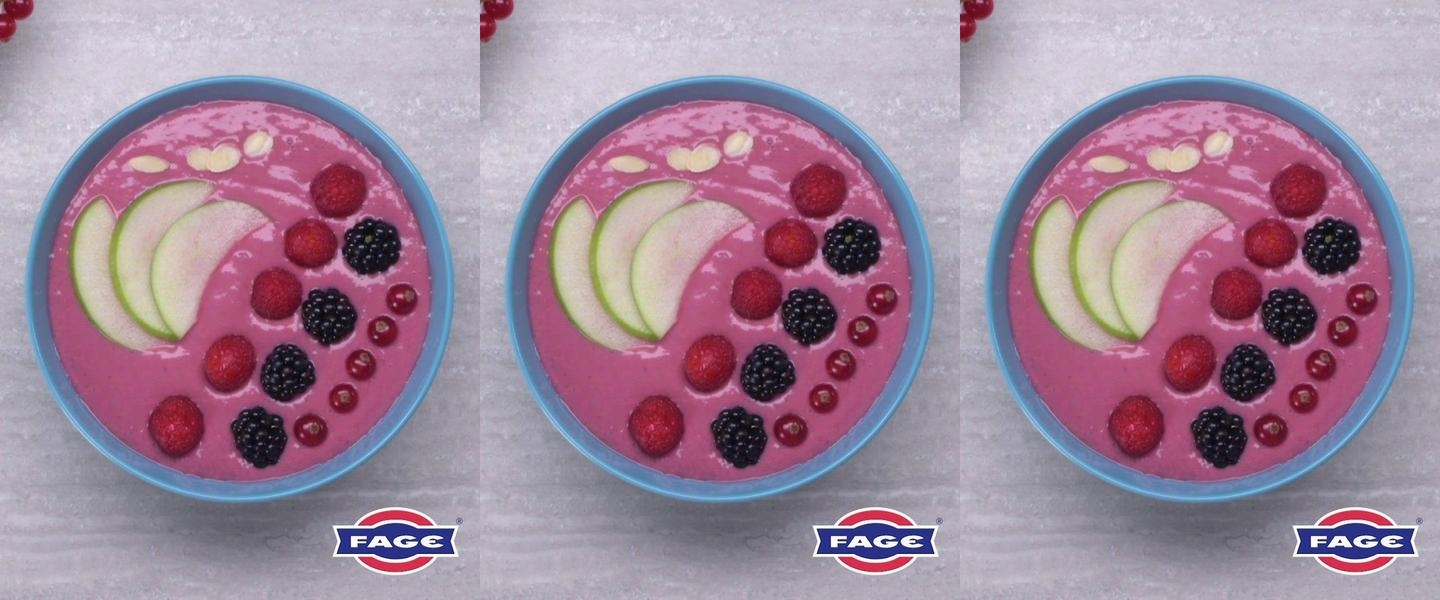
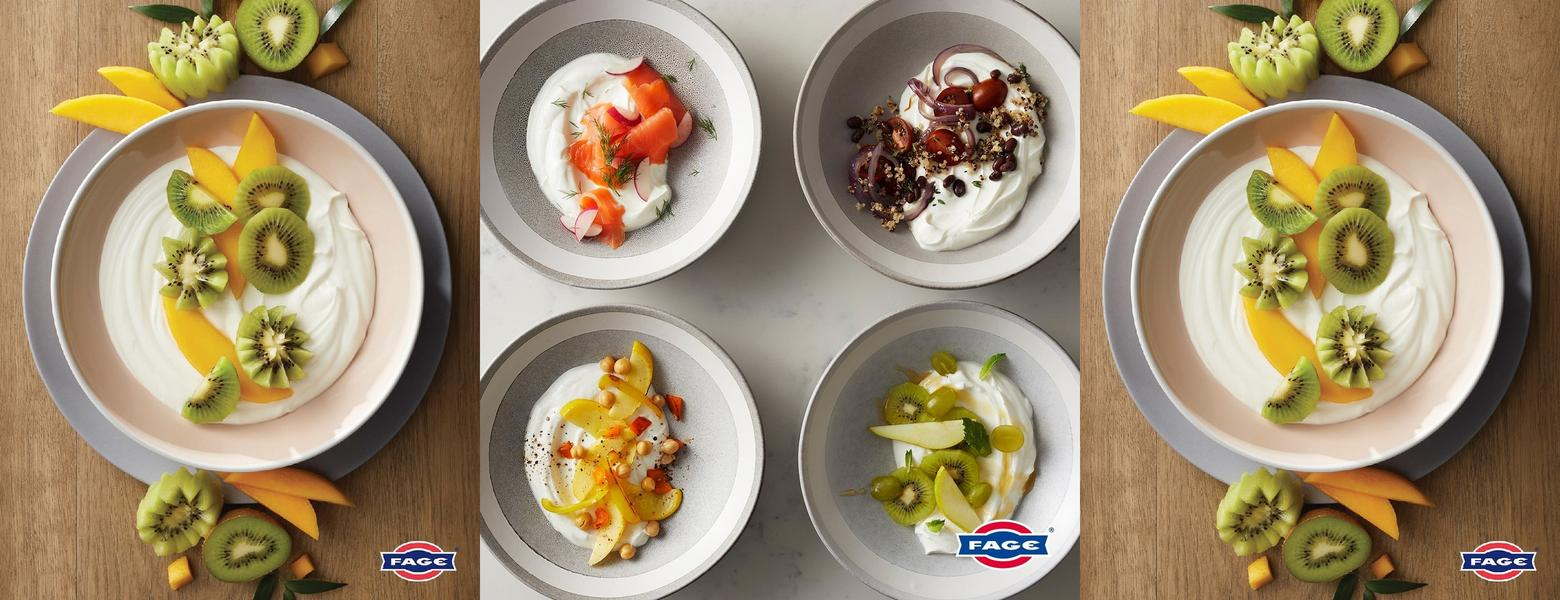
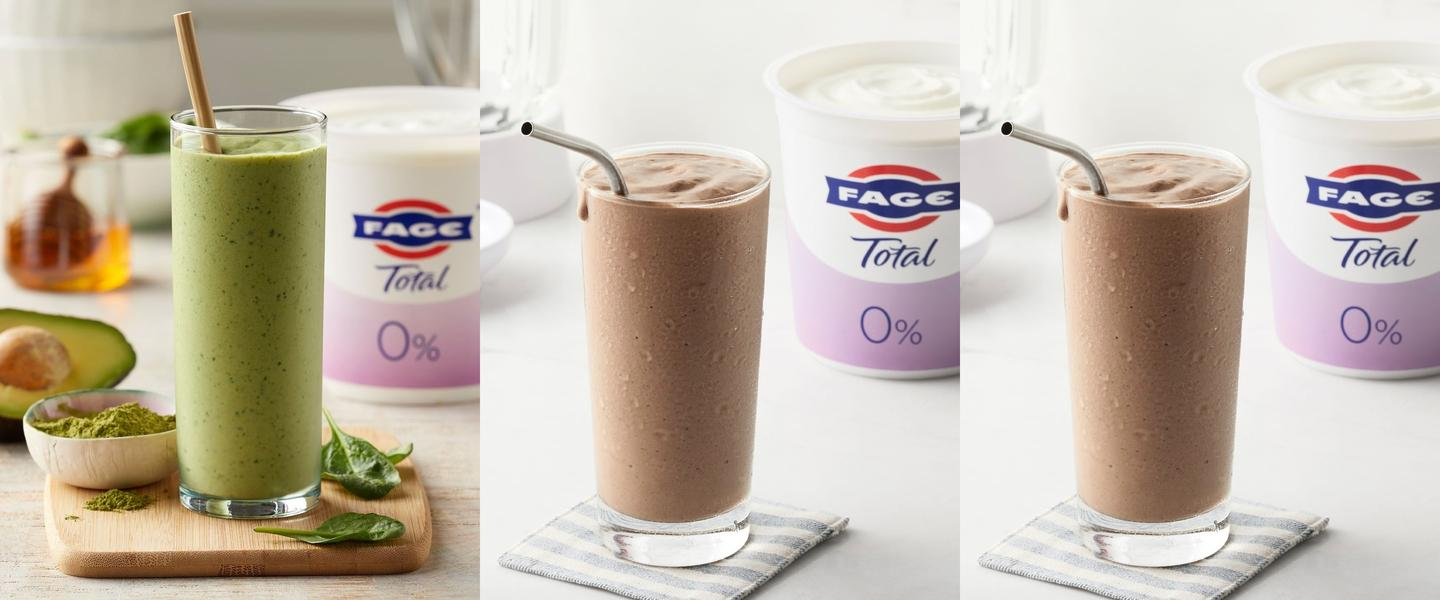
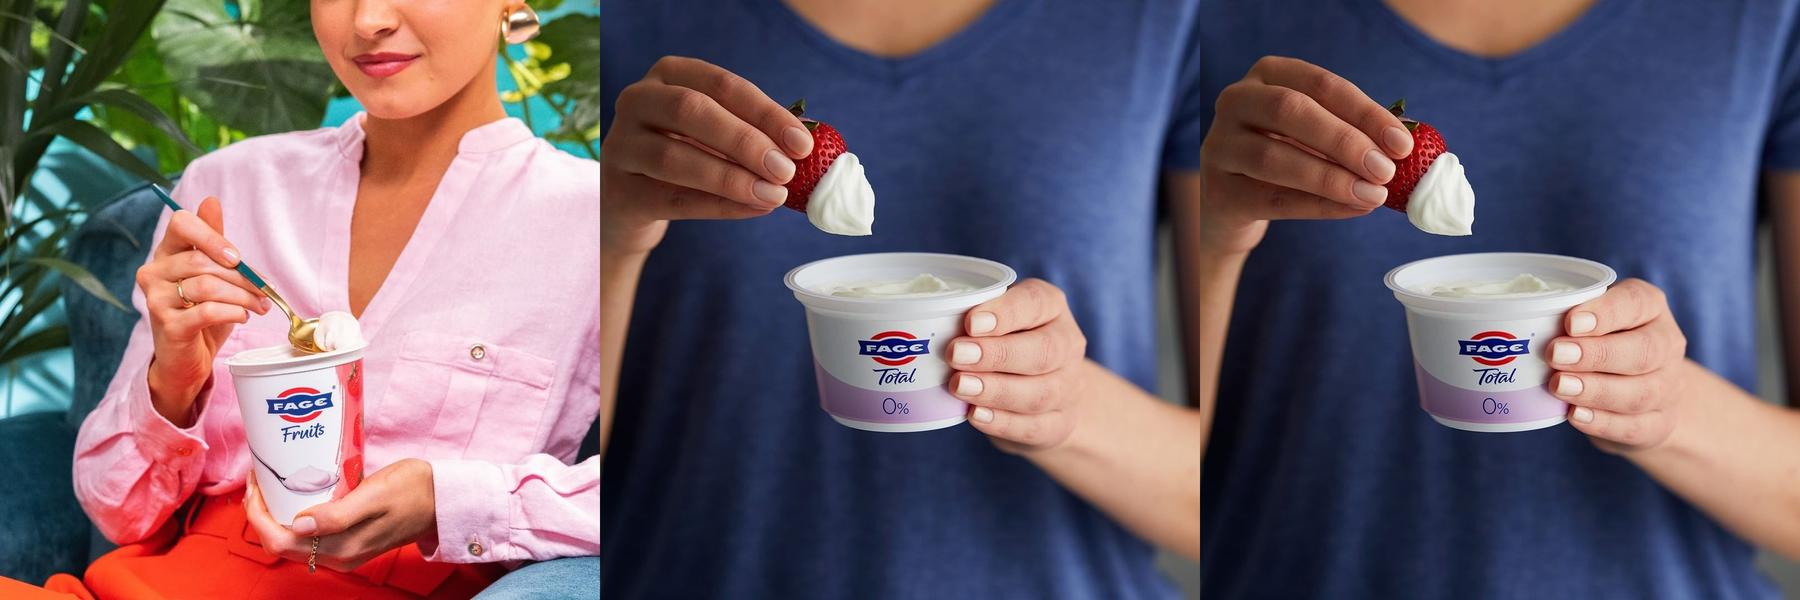
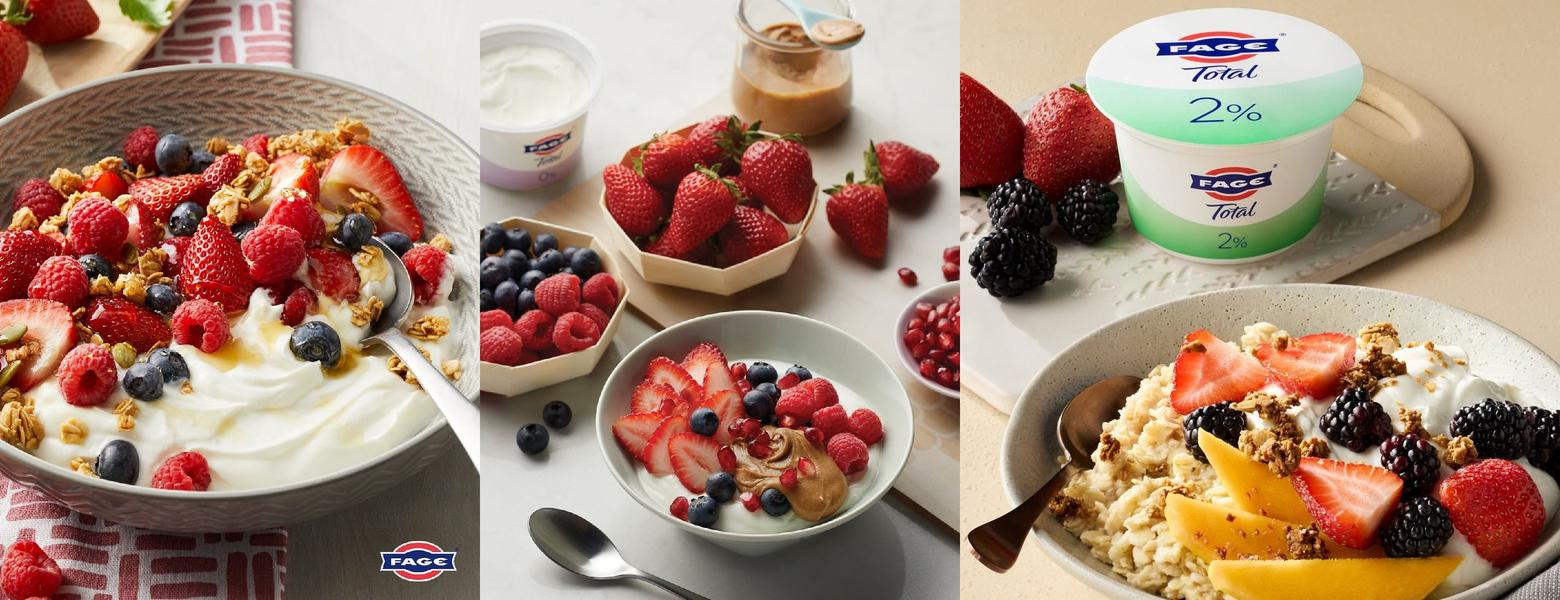
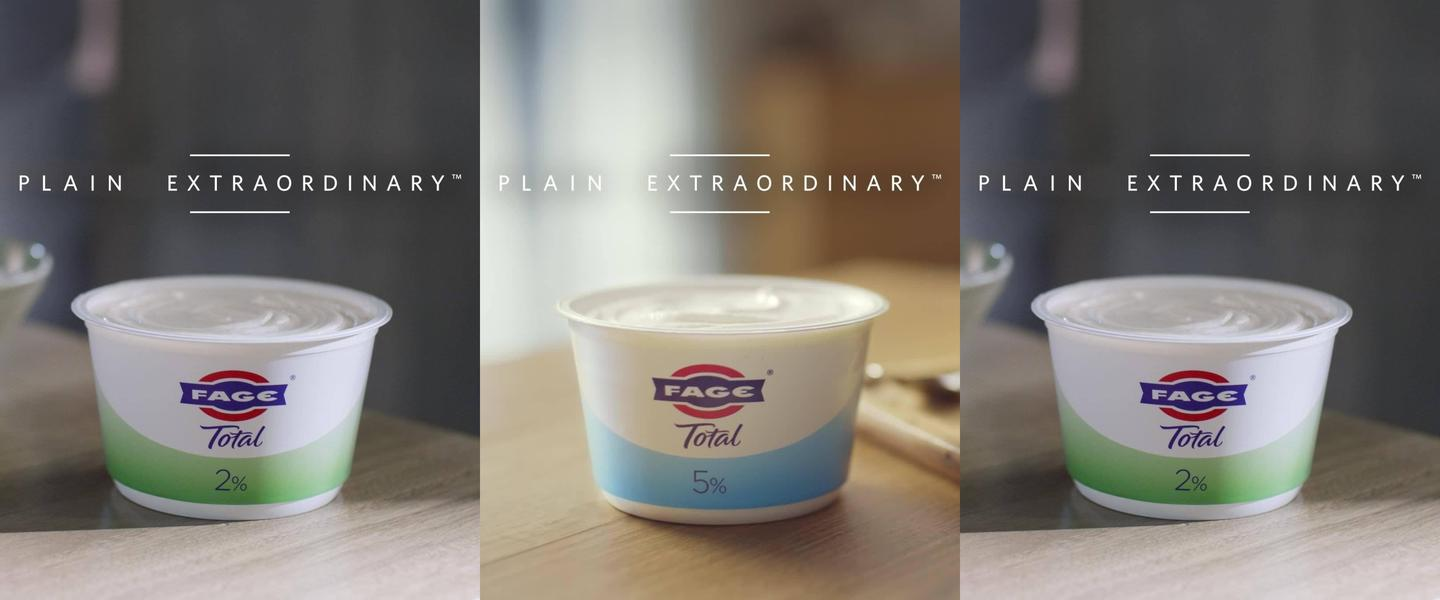
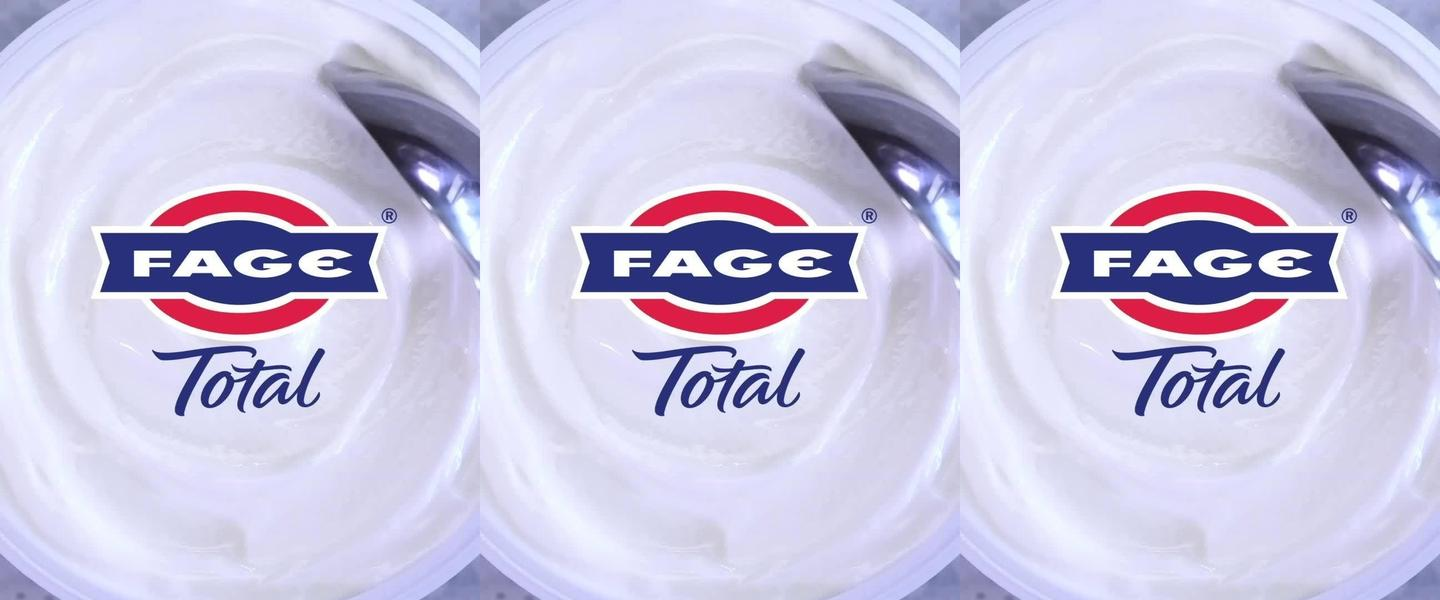
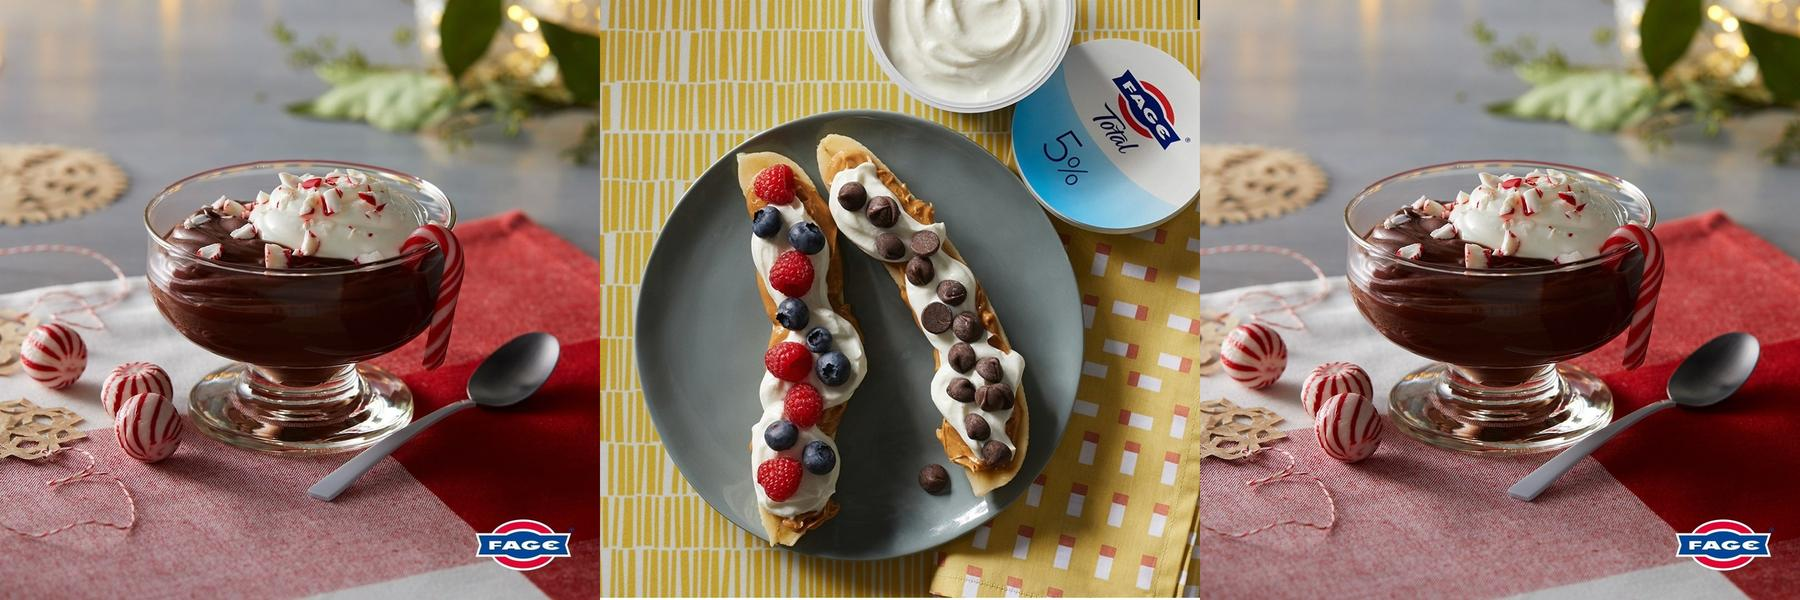
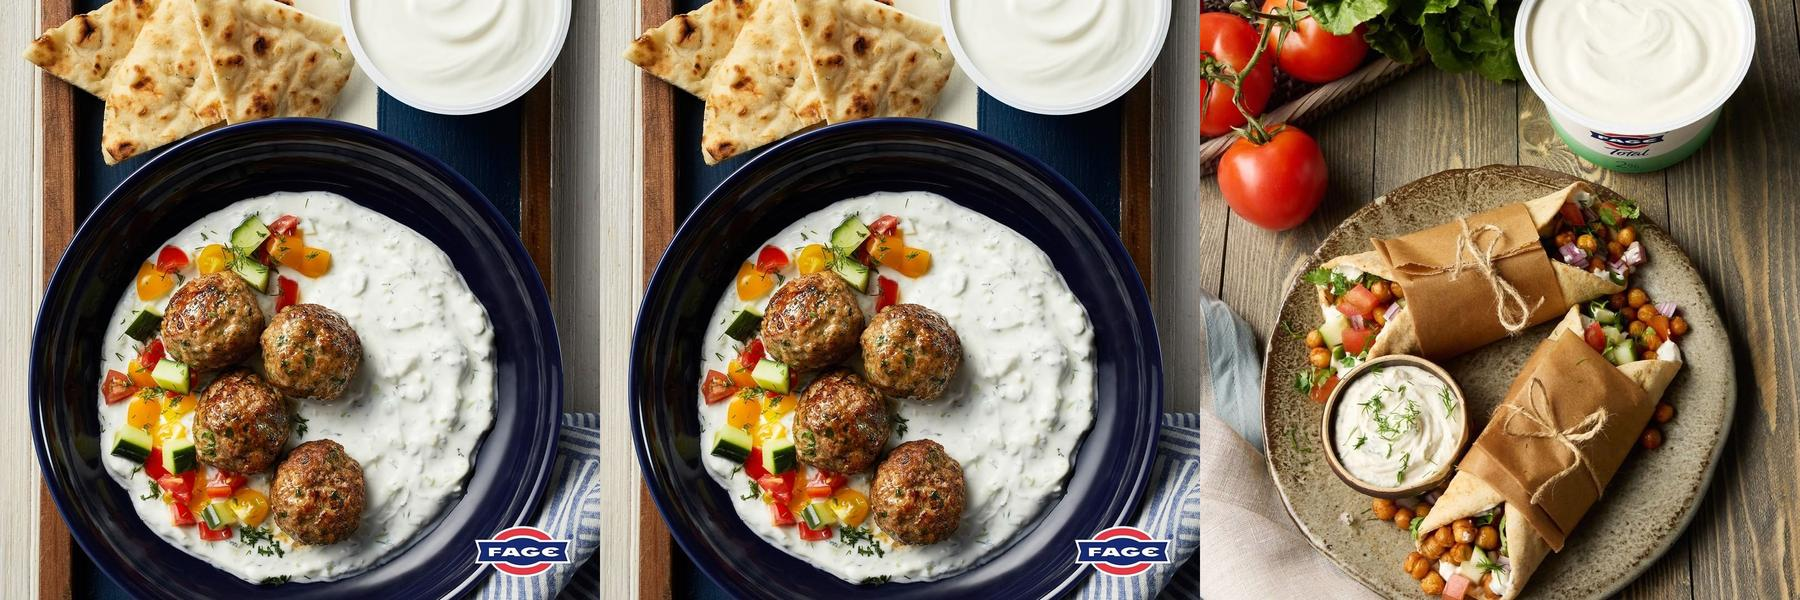
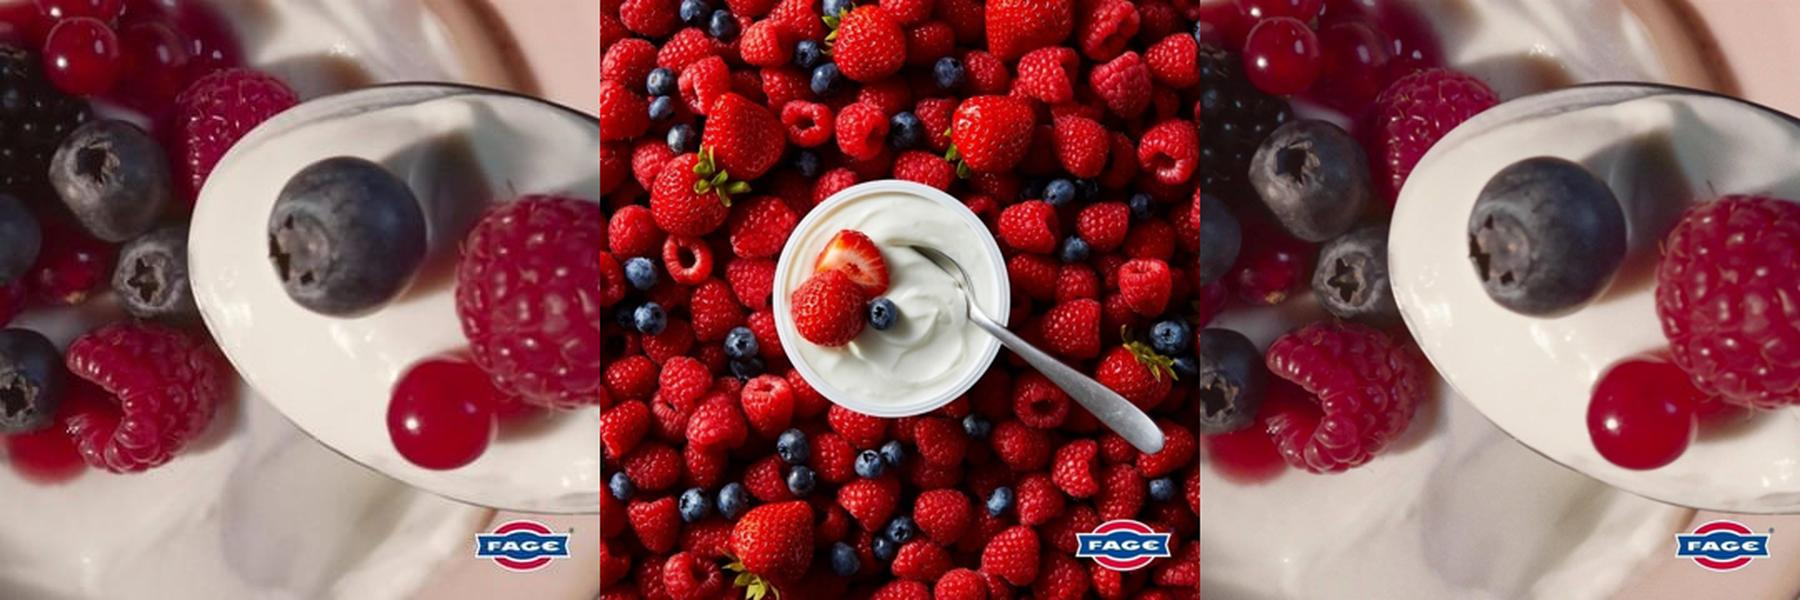
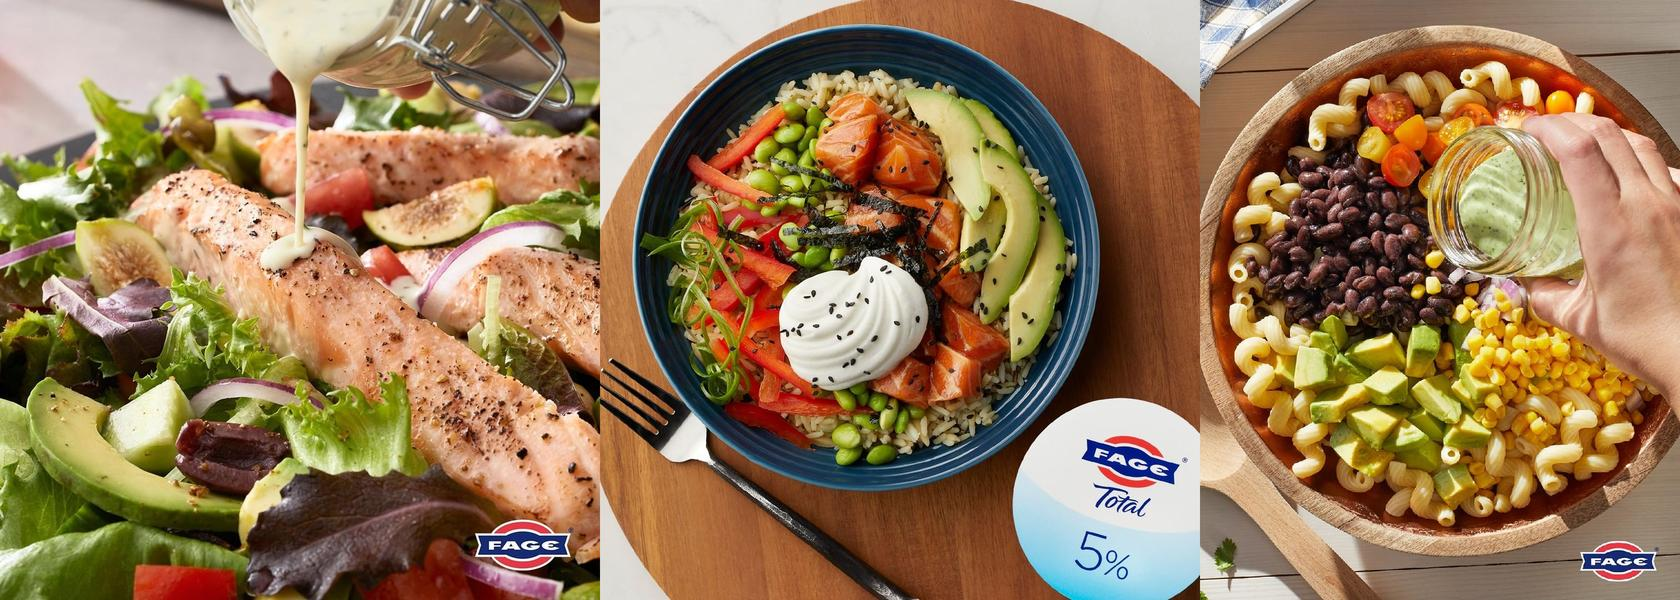
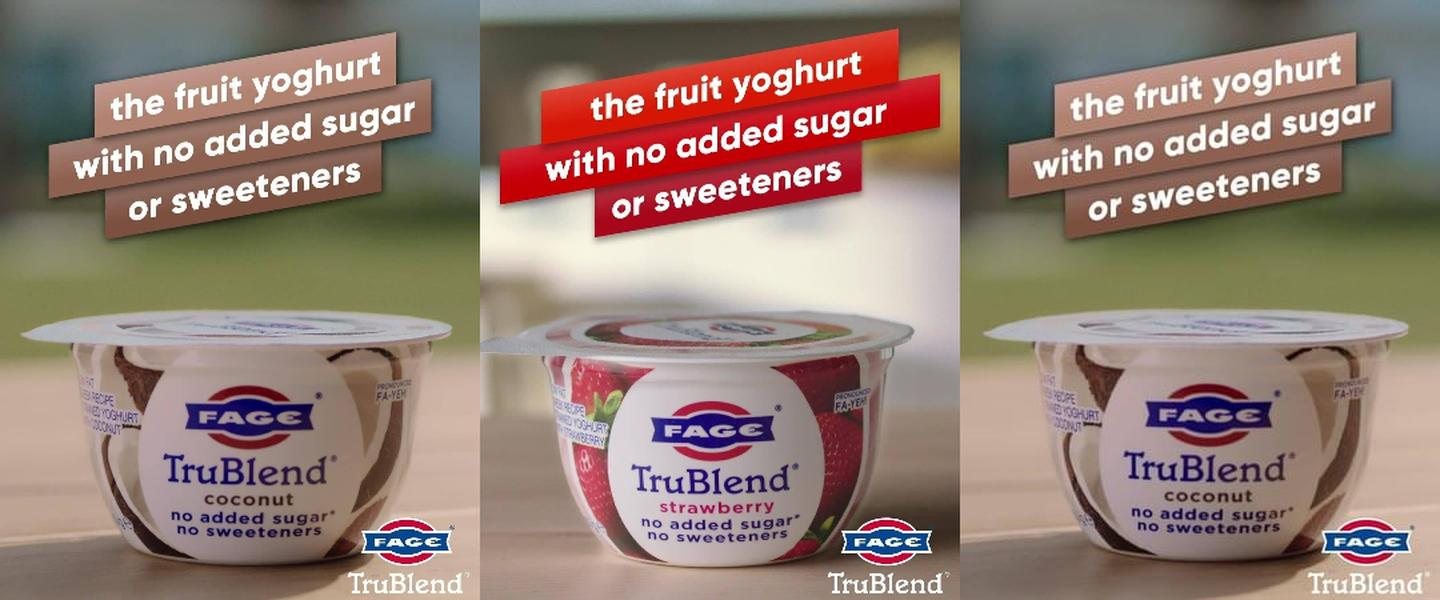
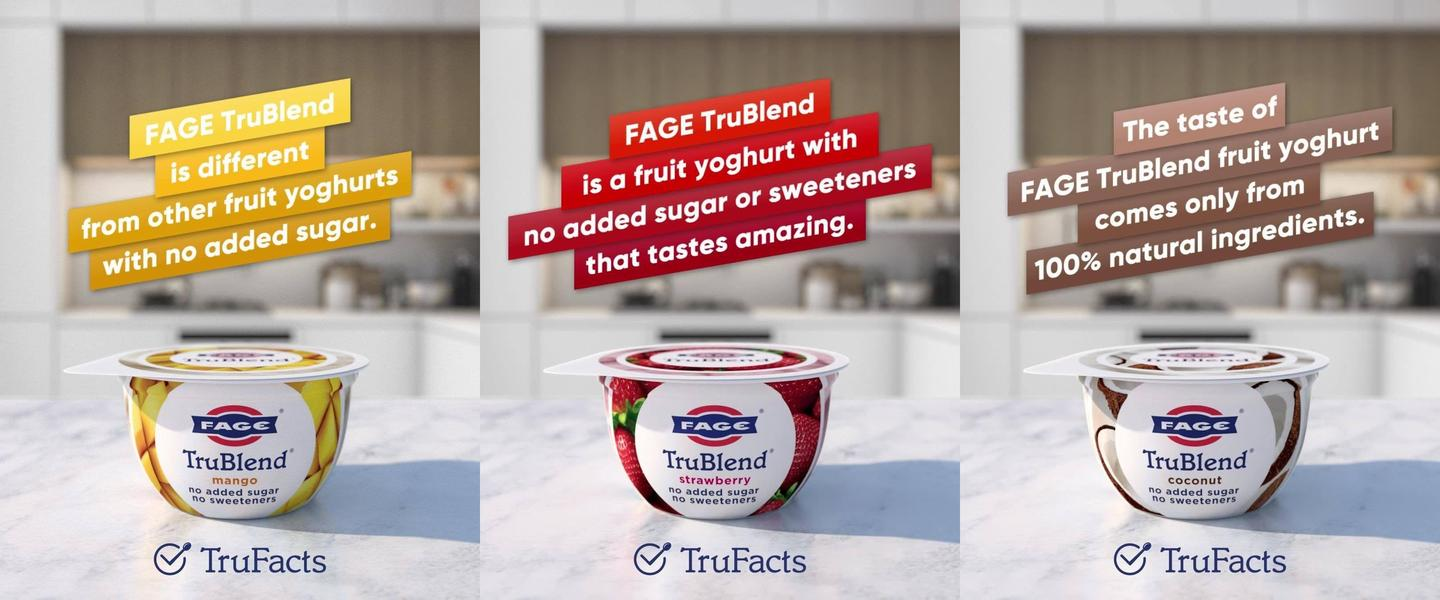
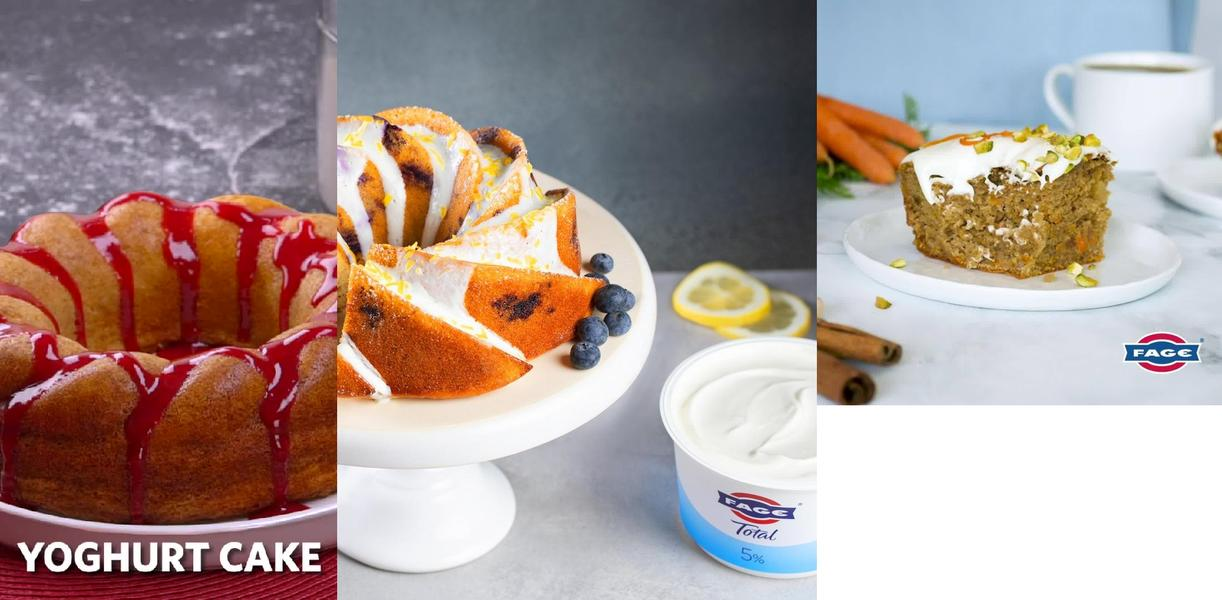
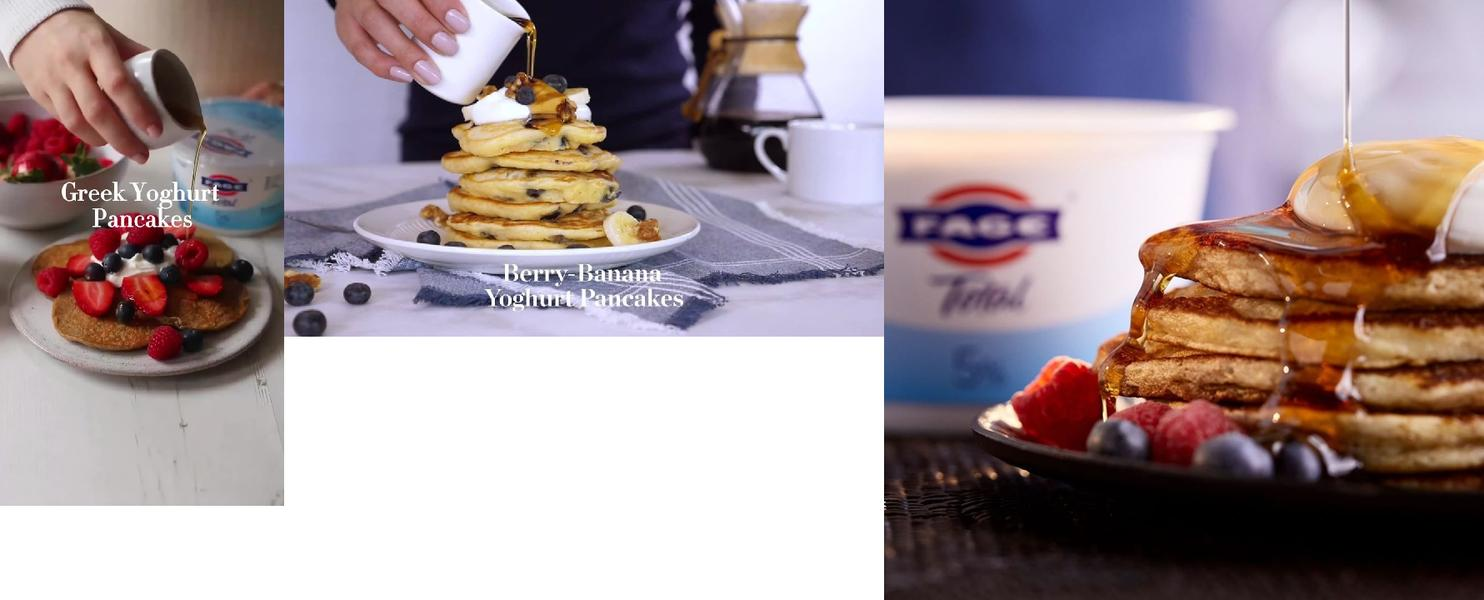
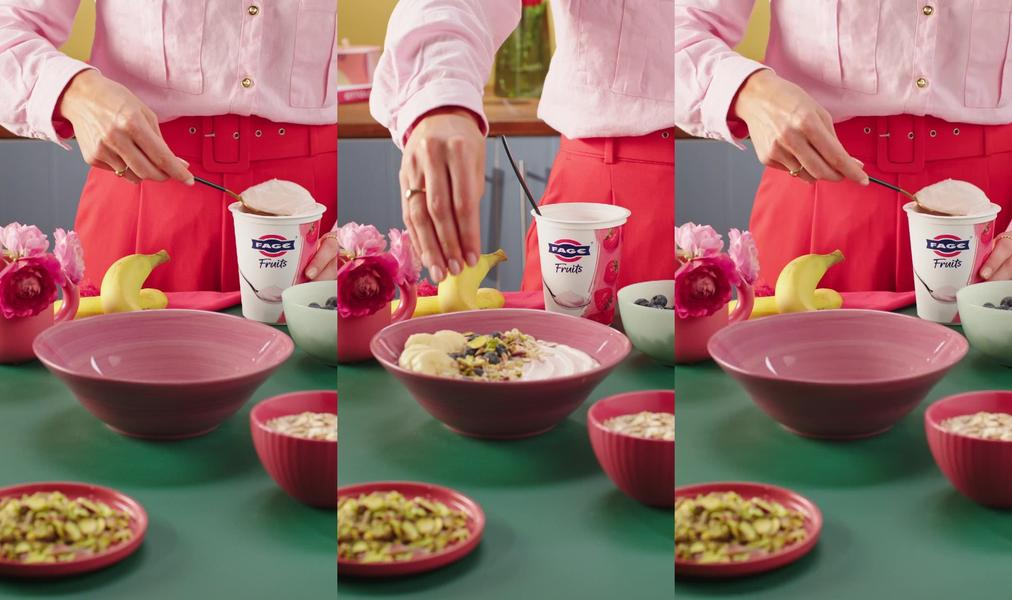
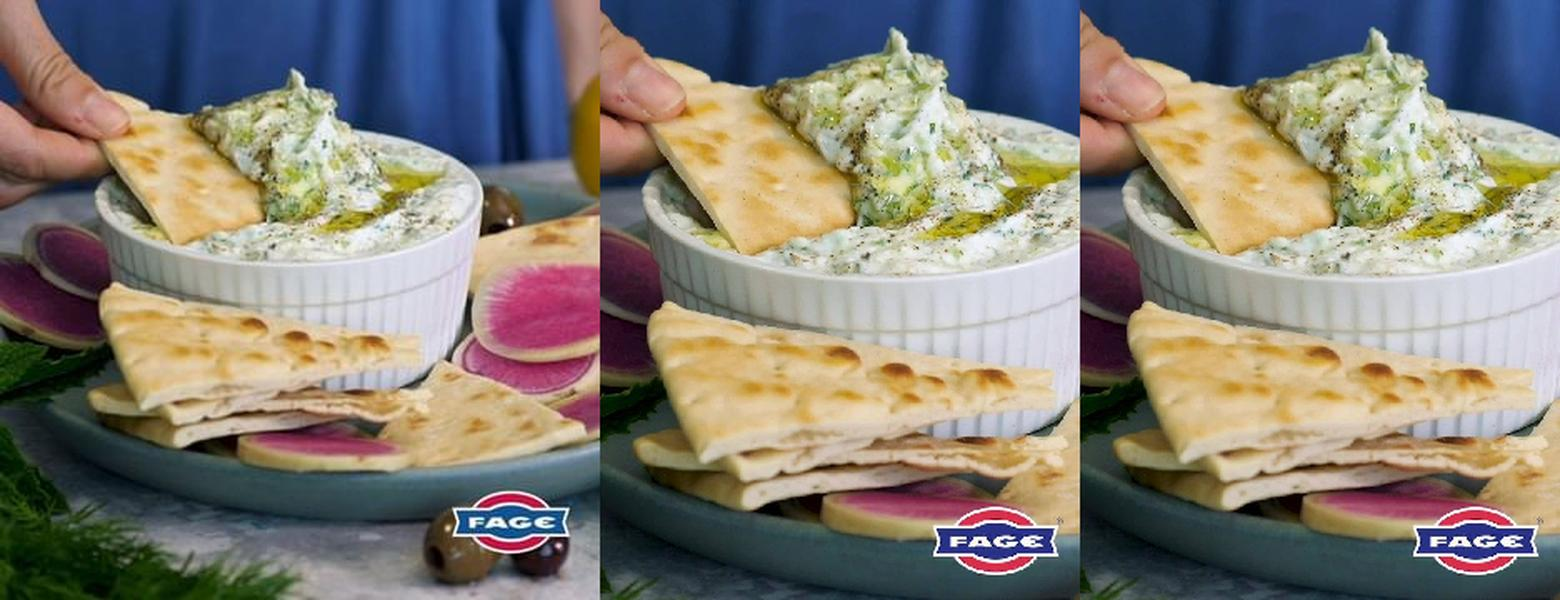

In [ ]:
import base64
from io import BytesIO
from IPython.display import HTML

def image_base64(im):
    if isinstance(im, str):
        im = Image.get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

# Extract dataframe
df=topic_model.get_topic_info().drop(['Representative_Docs', 'Name'], axis=1)

HTML(df.to_html(formatters={'Visual_Aspect': image_formatter}, escape=False))

# Inference

In [ ]:
for i in range(5):
  print()
  print(topic_model.transform(documents=[what_narr[i]], embeddings=super_embeddings[i].reshape(1, -1)))
  print('-----')



([np.int64(4)], array([1.]))
-----

([np.int64(8)], array([0.86349018]))
-----

([np.int64(3)], array([1.]))
-----

([np.int64(11)], array([1.]))
-----

([np.int64(16)], array([1.]))
-----
